Experiement Sampling

In [4]:
import pandas as pd
import numpy as np
import faker

import scipy
import scipy.stats as stats
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.pyplot as plt
import math

Fake case: 

Every customer service agent has a customer rating. To reduce customer complaints and improve rating, the company plans to roll out a X hour training. Before scaling up the program, the company would like to run an experiement to see whether the training helps reduce customer complaints. 

Step 1 Create a dummy sample data set

In [3]:
fake = faker.Faker()

# function to create a dataframe with fake values for our workers
def create_agents(num):
    
    state = [fake.state() for x in range(10)]

    agents = [{'Agent ID': x + 1000,
                  'Agent Name': fake.name(), 
                #   'Agent Tenure': int(np.random.uniform(0, 1000, 1)), 
                #   'State': np.random.choice(state),
                  'Compliant Rate': np.random.rand() * 0.5, # complaint rate between 0 and 50%, uniform dist.
                  'Customer Calls': int(np.random.uniform(0, 2000, 1)) # customer calls received between 0 and 2000, uniform dist.
                  } for x in range(num)
                ]
        
    return agents

df_agent = pd.DataFrame(create_agents(num = 1000))
df_agent.head()

,Agent ID,Agent Name,Compliant Rate,Customer Calls
0,1000,Amanda Callahan,0.014869,143
1,1001,Robert Blair,0.102528,1922
2,1002,Thomas Melendez,0.057462,784
3,1003,Devin Blackburn,0.491513,1106
4,1004,Sheila Moore,0.111153,1844


Design A/B Group based on Compliant Rate and Customer Calls

In [7]:
def sampling(df):
	
	# calculate Mahalanobis Distance
	def mashi_distance(x, y):

		X = np.vstack([x,y])		
		XT = X.T
		
		try:
			S = np.cov(X)
			SI = np.linalg.inv(S)
			n = XT.shape[0]
			d1 = []
			
			for i in range(0,n):
				for j in range(i+1, n):
					delta = XT[i] - XT[j]
					d = np.sqrt(np.dot(np.dot(delta, SI), delta.T))
					d1.append(d)

		except:
			d1 = [0]
		
		return d1
					
	agent_cnt = len(df_agent.index)
	n1 = math.floor(agent_cnt / 2)
	n2 = n1	
	
	count = 0
	distance1 = [3]
	distance2 = [3]
	
	while count < 1000:
		if sum(distance1) / len(distance1) < 1.5 and sum(distance2) / len(distance2) < 1.5:
			break
		else:
			count = count + 1
			df1 = df.sample(n = n1)
			df2 = df[~df.index.isin(df1.index)]
			df2 = df2.sample(n = n2)
			
			x_list1 = df1['Compliant Rate'].to_list()
			y_list1 = df2['Compliant Rate'].to_list()
		
			x_list2 = df1['Customer Calls'].to_list()
			y_list2 = df2['Customer Calls'].to_list()
			
			distance1 = mashi_distance(x_list1, y_list1)
			distance2 = mashi_distance(x_list2, y_list2)
	   
	print(count)
	
	return df1, df2

df_treatment = pd.DataFrame()
df_control = pd.DataFrame()
df_treatment, df_control = sampling(df_agent)


1000


In [17]:
print("Mean of treatment group:", df_treatment['Compliant Rate'].mean())
print("Mean of treatment group:", df_control['Compliant Rate'].mean())

print("Mean of control group:", df_treatment['Customer Calls'].mean())
print("Mean of control group:", df_control['Customer Calls'].mean())

Mean of treatment group: 0.2410562163425962
Mean of treatment group: 0.26461695172579563
Mean of control group: 975.094
Mean of control group: 993.424


In [ ]:
df_treatment['Group'] = 'Treatment'
df_control['Group'] = 'Control'
df_AB = pd.concat([df_treatment, df_control])

In [31]:
df_AB.groupby('Group')['Compliant Rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,500.0,0.264617,0.145624,0.000912,0.137370,0.276133,0.396895,0.49987
Treatment,500.0,0.241056,0.147065,0.002813,0.108638,0.249636,0.361601,0.49944


In [32]:
df_AB.groupby('Group')['Customer Calls'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,500.0,993.424,563.777167,6.0,503.75,978.0,1476.25,1999.0
Treatment,500.0,975.094,561.488482,2.0,469.75,990.0,1435.00,1993.0


In [33]:
# check normality using Shapiro-Wilks test
df_AB.groupby('Group')['Compliant Rate'].apply(stats.shapiro)

Group
Control      (0.9466129541397095, 1.925934021637654e-12)
Treatment    (0.9479154348373413, 2.927379909659078e-12)
Name: Compliant Rate, dtype: object

In [34]:
df_AB.groupby('Group')['Customer Calls'].apply(stats.shapiro)

Group
Control      (0.9560896754264832, 4.8114758705031235e-11)
Treatment     (0.9578869342803955, 9.310815313190446e-11)
Name: Customer Calls, dtype: object

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D196B6A630>,
      dtype=object)

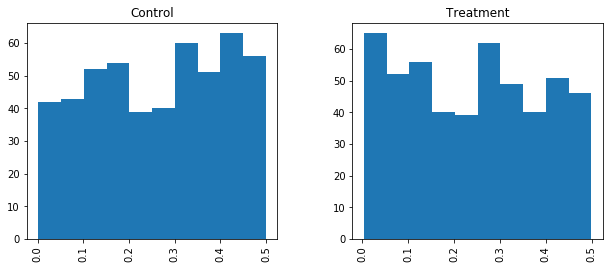

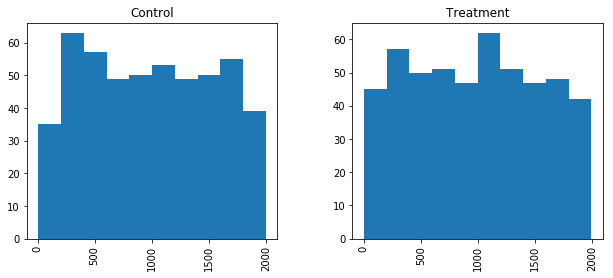

In [43]:
df_AB.hist(by='Group',column='Compliant Rate', figsize=[10, 4])
df_AB.hist(by='Group',column='Customer Calls', figsize=[10, 4])

In [46]:
stats.levene(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

LeveneResult(statistic=0.011068781195340462, pvalue=0.9162316852269224)

In [26]:
scipy.stats.ttest_ind(df_treatment['Compliant Rate'].to_list(), df_control['Compliant Rate'].to_list(), axis=0, equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=-2.5455237083338353, pvalue=0.011060860430095618)